# CISC/CMPE 452/COGS 400 Assignment 1 - Perceptron (10 points)  

Please put your name and student id here

    Kieran Cosgrove, #20226841

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)



### Build Model (6 points)  
Implement **Simple Feedback Learning** for emotion classification (dataset from: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)

Use the correct/incorrect feedback and info about (y>d) or (y<d) to change weights.  
Refer to the **Perceptron slides**  

- 1. Implement forward and calculate the output (2 point)  
- 2. Update the weights and bias (2 points)  
- 3. Predict function (1 point)  
- 4. Activation function (1 point)  

### Evaluator Function (2 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate the Model (2 point)  
Train the model with customized learning rate and number of iterations  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load dataset
df_train = pd.read_csv('data/train.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('data/test.txt', names=['Text', 'Emotion'], sep=';')

In [3]:
x_train = df_train['Text']
y_train = df_train['Emotion']

x_test = df_test['Text']
y_test = df_test['Emotion']

df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df_train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

## Data Preprocessing

In [5]:
# encode label
y_train = y_train.replace({'joy':1, 'sadness':0, 'anger':0, 'fear':0, 'love':1, 'surprise':1})
y_test = y_test.replace({'joy':1, 'sadness':0, 'anger':0, 'fear':0, 'love':1, 'surprise':1})

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5)#, stop_words='english')

# We transform each text into a vector
x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()

In [7]:
def evaluator(y_test, y_pred):
    ####################################################################################################
    # Accuracy
    accuracy = np.sum(y_test == y_pred) / len(y_test)
    
    # Confusion matrix
    TP = np.sum((y_test == 1) & (y_pred == 1))
    TN = np.sum((y_test == 0) & (y_pred == 0))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    FN = np.sum((y_test == 1) & (y_pred == 0))
    confusion_matrix = np.array([[TP, FP], [FN, TN]])
    
    # Precision
    precision = TP / (TP + FP)
    
    # Recall
    recall = TP / (TP + FN)
    
    # F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall))
    
    return confusion_matrix, accuracy, recall, precision, f1_score

    ####################################################################################################

In [8]:
class SimpleFeedbackLearning(object):
    def __init__(self):
        self.history = {}
        self.history['train_acc'] = []
        self.history['test_acc'] = []
        
    def f(self, x):
        ####################################################################################################
        # 4. enter code here to implement the activation function
        #return np.where(self.W.T.dot(x) + self.b > 0, 1, 0)
        #fx = np.where(np.dot(self.W.T, x) + self.b > 0, 1, 0)
        fx = np.maximum(0, x)
        ####################################################################################################
        return fx
    
    def train(self, x, y, x_test, y_test, learning_rate=0.1, n_iters=10, verbose=True):
        n_train, input_size = x.shape
        n_test = x_test.shape[0]
        # weight initialization
        self.W = np.zeros(input_size)
        self.b = np.zeros(1)

        for i in range(n_iters):
            for xi, yi in zip(x, y):
                # forward
                ####################################################################################################
                # 1. enter code here to calculate the output
                Dotproduct = np.dot(xi, self.W) + self.b
                output = self.f(Dotproduct)

                ####################################################################################################

                ####################################################################################################
                # # 2. enter code here to adjust the weights and bias
                
                # # Simple Feedback learning
                error = output - yi
                
                if error > 0:
                    # Output higher than expected, widely reduce weights
                    self.W = self.W - learning_rate * xi
                    self.b = self.b - learning_rate
                elif error < 0:
                    # Output lower than expected, increase weights slightly  
                    self.W = self.W + learning_rate * xi
                    self.b = self.b + learning_rate
                    
                # # Error Correction
                # self.W = self.W + learning_rate * (yi - output) * xi
                # self.b = self.b + learning_rate * (yi - output)

                ####################################################################################################

            train_acc = (self.predict(x) == y).sum() / n_train
            test_acc = (self.predict(x_test) == y_test).sum() / n_test
            self.history['train_acc'].append(train_acc)
            self.history['test_acc'].append(test_acc)
            if verbose:
                print('epoch %d, train acc %.4f, test acc %.4f' % (i + 1, train_acc, test_acc))

    def predict(self, x):
        ####################################################################################################
        # 3. enter code here to complete the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels #need to figure out grater or less than 0.5
        Dotproduct = np.dot(x, self.W) + self.b
        y_pred = np.round(self.f(Dotproduct))
        ####################################################################################################
        return y_pred

In [9]:
####################################################################################################
# enter code here to initialize and train the model
model1 = SimpleFeedbackLearning()
model1.train(x_train, y_train, x_test, y_test, learning_rate=0.01, n_iters=100)
####################################################################################################


epoch 1, train acc 0.5534, test acc 0.5450
epoch 2, train acc 0.7373, test acc 0.7250
epoch 3, train acc 0.8684, test acc 0.8625
epoch 4, train acc 0.9137, test acc 0.9050
epoch 5, train acc 0.9262, test acc 0.9245
epoch 6, train acc 0.9266, test acc 0.9240
epoch 7, train acc 0.9379, test acc 0.9350
epoch 8, train acc 0.9472, test acc 0.9420
epoch 9, train acc 0.9516, test acc 0.9425
epoch 10, train acc 0.9569, test acc 0.9460
epoch 11, train acc 0.9584, test acc 0.9475
epoch 12, train acc 0.9583, test acc 0.9500
epoch 13, train acc 0.9571, test acc 0.9495
epoch 14, train acc 0.9592, test acc 0.9505
epoch 15, train acc 0.9593, test acc 0.9495
epoch 16, train acc 0.9622, test acc 0.9510
epoch 17, train acc 0.9619, test acc 0.9520
epoch 18, train acc 0.9623, test acc 0.9510
epoch 19, train acc 0.9625, test acc 0.9510
epoch 20, train acc 0.9627, test acc 0.9510
epoch 21, train acc 0.9625, test acc 0.9495
epoch 22, train acc 0.9629, test acc 0.9500
epoch 23, train acc 0.9633, test acc 0.95

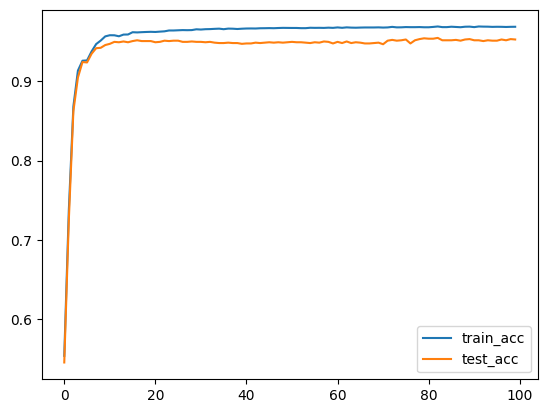

In [10]:
# plot the accuracy
plt.plot(model1.history['train_acc'], label='train_acc')
plt.plot(model1.history['test_acc'], label='test_acc')
plt.legend()
plt.show()

In [11]:
####################################################################################################
# enter code here to evaluate the model with the evaluator function
y_pred_train = model1.predict(x_train)
confusion_matrix_train, accuracy_train, recall_train, precision_train, f1_score_train = evaluator(y_train, y_pred_train)
print('Training Data:')
print('Confusion Matrix:\n', confusion_matrix_train)
print('Accuracy: ', accuracy_train)
print('Recall: ', recall_train)
print('Precision: ', precision_train)
print('F1 Score: ', f1_score_train, '\n')

# Evaluate testing data
y_pred_test = model1.predict(x_test)
confusion_matrix_test, accuracy_test, recall_test, precision_test, f1_score_test = evaluator(y_test, y_pred_test)
print('Testing Data:')
print('Confusion Matrix:\n', confusion_matrix_test)
print('Accuracy: ', accuracy_test)
print('Recall: ', recall_test)
print('Precision: ', precision_test)
print('F1 Score: ', f1_score_test)

####################################################################################################

Training Data:
Confusion Matrix:
 [[6870  127]
 [ 341 8635]]
Accuracy:  0.9690625
Recall:  0.9527111357648038
Precision:  0.9818493640131485
F1 Score:  0.9670608108108109 

Testing Data:
Confusion Matrix:
 [[ 862   36]
 [  52 1044]]
Accuracy:  0.953
Recall:  0.9431072210065645
Precision:  0.9599109131403119
F1 Score:  0.9514348785871964
